# Evaluamos con algunas métricas

Primero, tenemos que evaluar por separado: single segmentation y multiple segmentation. Además siempre tener en cuenta que hay que separar por label.

In [10]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
base_path = '/home/cbolanos/experiments/audioset_evaluation/'

files_auc_new_alg = [
    f'{base_path}/auc/hyperparams/order_linear_regression_p{{}}_m{{}}.tsv',
    f'{base_path}/auc/hyperparams/order_naive_p{{}}_m{{}}.tsv',
    f'{base_path}/auc/hyperparams/order_shap_p{{}}_m{{}}.tsv',
    f'{base_path}/auc/hyperparams/order_tree_importance_p{{}}_m{{}}.tsv'
]

files_auc = [
    f'{base_path}/auc/order_linear_regression.tsv',
    f'{base_path}/auc/order_naive.tsv',
    f'{base_path}/auc/order_shap.tsv',
    f'{base_path}/auc/order_tree_importance.tsv'
]

files_curve_new_alg = [
    f'{base_path}/leo_metric/hyperparams/score_curve_linear_regression_p{{}}_m{{}}.tsv',
    f'{base_path}/leo_metric/hyperparams/score_curve_naive_p{{}}_m{{}}.tsv',
    f'{base_path}/leo_metric/hyperparams/score_curve_shap_p{{}}_m{{}}.tsv',
    f'{base_path}/leo_metric/hyperparams/score_curve_tree_importance_p{{}}_m{{}}.tsv'
]

files_curve = [
    f'{base_path}/leo_metric/score_curve_linear_regression.tsv',
    f'{base_path}/leo_metric/score_curve_naive.tsv',
    f'{base_path}leo_metric/score_curve_shap.tsv',
    f'{base_path}/leo_metric/score_curve_tree_importance.tsv'
]

methods = ['linear_regression', 'naive', 'shap', 'tree_importance']

mask_percentages = [0.1, 0.15, 0.2, 0.3, 0.4]
window_sizes = [1, 2, 3, 4, 5, 6]

In [4]:
import pandas as pd
import numpy as np
from typing import List, Dict, Any, Optional, Tuple
import re
from itertools import product

class DataMerger:
    def __init__(self, labels_segments_file: str):
        """
        Initialize the DataMerger with segment and reference files.
        
        Args:
            labels_segments_file: Path to the segments file
        """
        self.segments_df = pd.read_csv(labels_segments_file)
        self._prepare_segments()
        
    def _prepare_segments(self):
        """Prepare segment filtering based on base_segment_id and father_labels"""
        # Count segments for each base_segment_id and father_label
        self.segment_counts = (self.segments_df.groupby(['base_segment_id', 'father_labels'])
                             .size()
                             .reset_index(name='segment_count'))
        
        # Identify base_segment_ids with multiple segments
        self.segment_counts = self.segment_counts.rename(columns={
            'base_segment_id': 'filename',
            'father_labels': 'event_label'
        })
    
    def _extract_params_from_filename(self, filename: str) -> Dict[str, int]:
        """
        Extract p and m parameters from the filename.
        
        Args:
            filename: The input filename containing p and m parameters
            
        Returns:
            Dictionary containing extracted p and m values
        """
        # Extract p and m values using regex
        p_match = re.search(r'p(\d+)', filename)
        m_match = re.search(r'm(\d+)', filename)
        
        params = {}
        if p_match:
            params['p'] = int(p_match.group(1))
        if m_match:
            params['m'] = int(m_match.group(1))
            
        return params
    
    def _generate_filenames(self, 
                          file_templates: List[str], 
                          p_values: List[int], 
                          m_values: List[int]) -> List[Tuple[str, int, int]]:
        """
        Generate actual filenames by substituting p and m values.
        
        Args:
            file_templates: List of filename templates containing {} placeholders
            p_values: List of values for p parameter
            m_values: List of values for m parameter
            
        Returns:
            List of tuples containing (filename, p_value, m_value)
        """
        all_files = []
        for template in file_templates:
            for p, m in product(p_values, m_values):
                filename = template.format(p, m)
                all_files.append((filename, p, m))
        return all_files
    
    def merge_curve_and_auc(self, 
                           file_templates_curve: List[str],
                           file_templates_auc: List[str],
                           methods: List[str],
                           p_values: List[int],
                           m_values: List[int],
                           additional_merge_columns: Optional[List[str]] = None) -> pd.DataFrame:
        """
        Merge curve and AUC data with enhanced handling.
        
        Args:
            file_templates_curve: List of curve data file templates
            file_templates_auc: List of AUC data file templates
            methods: List of method names
            p_values: List of values for p parameter
            m_values: List of values for m parameter
            additional_merge_columns: Optional additional columns to include in merge
            
        Returns:
            Merged DataFrame containing both curve and AUC data
        """
        # Generate actual filenames for curve data
        all_curve_files = []
        for template, method in zip(file_templates_curve, methods):
            curve_files = self._generate_filenames([template], p_values, m_values)
            all_curve_files.extend([(f, p, m, method) for f, p, m in curve_files])
        
        # Process curve data
        all_curve_data = []
        for file, p, m, method in all_curve_files:
            try:
                df = pd.read_csv(file, sep='\t')
                df['method'] = method
                df['p'] = p
                df['m'] = m
                all_curve_data.append(df)
            except Exception as e:
                print(f"Error processing curve file {file}: {str(e)}")
                continue
        
        if not all_curve_data:
            raise ValueError("No curve data could be processed")
            
        # Combine curve data
        curve_df = pd.concat(all_curve_data, ignore_index=True)
        
        # Generate actual filenames for AUC data
        all_auc_files = []
        for template, method in zip(file_templates_auc, methods):
            auc_files = self._generate_filenames([template], p_values, m_values)
            all_auc_files.extend([(f, p, m, method) for f, p, m in auc_files])
        
        # Process AUC data
        all_auc_data = []
        for file, p, m, method in all_auc_files:
            try:
                df = pd.read_csv(file, sep='\t')
                df['method'] = method
                df['p'] = p
                df['m'] = m
                
                # Select columns for AUC data
                columns_to_keep = ['filename', 'event_label', 'roc_auc', 'method', 'p', 'm']
                if additional_merge_columns:
                    columns_to_keep.extend(additional_merge_columns)
                
                all_auc_data.append(df[columns_to_keep])
            except Exception as e:
                print(f"Error processing AUC file {file}: {str(e)}")
                continue
        
        if not all_auc_data:
            raise ValueError("No AUC data could be processed")
            
        # Combine AUC data
        auc_df = pd.concat(all_auc_data, ignore_index=True)
        
        # Perform the merge
        merge_columns = ['filename', 'event_label', 'method', 'p', 'm']
        if additional_merge_columns:
            merge_columns.extend(additional_merge_columns)
            
        merged_df = curve_df.merge(
            auc_df,
            on=merge_columns,
            how='left',
            validate='many_to_one'  # Ensure proper merge relationship
        )
        

            # Then merge with the pre-calculated segment counts
        final_merged_df = merged_df.merge(
                self.segment_counts,
                on=['filename', 'event_label'],
                how='left'
            )
            
        final_merged_df['type_segment'] = np.where(
            final_merged_df['segment_count'] == 1, 'single', 'multiple')
        
        
        return final_merged_df

In [5]:
merger = DataMerger('/home/cbolanos/experiments/audioset/labels/labels_segments.csv')

merge_df = merger.merge_curve_and_auc(files_curve_new_alg, files_auc_new_alg, methods, mask_percentages, window_sizes)

In [6]:
merge_df['pair'] = list(zip(merge_df['filename'], merge_df['event_label']))

# Group by the specified columns and count unique pairs
grouped = merge_df.groupby(['method', 'p', 'm', 'type_segment']).agg({
    'pair': pd.Series.nunique  # Count unique (filename, event_label) pairs
}).reset_index()

# Rename the column for clarity
grouped.rename(columns={'pair': 'unique_pairs_count'}, inplace=True)

print(grouped)


                method    p  m type_segment  unique_pairs_count
0    linear_regression  0.1  1     multiple                  54
1    linear_regression  0.1  1       single                  36
2    linear_regression  0.1  2     multiple                  54
3    linear_regression  0.1  2       single                  36
4    linear_regression  0.1  3     multiple                  54
..                 ...  ... ..          ...                 ...
235    tree_importance  0.4  4       single                  36
236    tree_importance  0.4  5     multiple                  54
237    tree_importance  0.4  5       single                  36
238    tree_importance  0.4  6     multiple                  54
239    tree_importance  0.4  6       single                  36

[240 rows x 5 columns]


In [11]:
import numpy as np

def calculate_normalized_score_difference(row):
    """
    Calculate the normalized difference between descending_lower and descending_higher scores.
    
    Args:
        row: A pandas Series containing 'score_curve_descending_lower' and 'score_curve_descending_higher'
        
    Returns:
        float: The average normalized difference across all positions
    """
    # Get the scores from both curves
    lower_scores = np.array(eval(row['score_curve_descending_lower']))
    higher_scores = np.array(eval(row['score_curve_descending_higher']))
     
    # Calculate the difference
    differences = lower_scores - higher_scores
     
    # min_abs_value = np.abs(min(np.min(lower_scores), np.min(higher_scores)))
    
    min_abs_value =  np.abs(np.array(eval(row['score_curve_descending_higher']))[-1])
    # min_abs_value = np.abs(almost_prior + row['actual_score'] )

    # Avoid division by zero by setting very small values to a small constant
    normalization_factor = min_abs_value if min_abs_value >= 1e-10 else 1e-10
    
    # Calculate normalized differences using the minimum absolute value
    normalized_differences = differences / normalization_factor
    
    # Calculate the average
    average_normalized_difference = np.sum(normalized_differences) / len(normalized_differences)
    
    return average_normalized_difference


merge_df['normalized_score_difference'] = merge_df.apply(calculate_normalized_score_difference, axis=1)

In [13]:
merge_df

,filename,event_label,actual_score,score_curve_descending_higher,score_curve_descending_lower,gt_curve_descending,importance_curve_descending,method,p,m,roc_auc,segment_count,type_segment,pair,normalized_score_difference,segment_category
0,-gBOhfAyaGI,Camera,-1.348212,"[-2.0126664638519287, -2.031116485595703, -5.1...","[-0.6822390556335449, -0.7375277280807495, -0....","[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1.8103235277417258, 1.6320237124226347, -0.60...",linear_regression,0.1,1,0.826531,1,single,"(-gBOhfAyaGI, Camera)",0.415195,Single Segment
1,-JJmkQYZA-4,Fowl,0.552986,"[-0.37127965688705444, -1.1904675960540771, -1...","[0.5538957118988037, 0.5498807430267334, 0.548...","[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, ...","[0.5757306221940746, 0.5208156224991247, 0.426...",linear_regression,0.1,1,0.912239,2,multiple,"(-JJmkQYZA-4, Fowl)",1.009224,Multiple Segments
2,0-N62G9etNE,Speech,-0.190030,"[0.5161032676696777, 0.739356517791748, 0.8919...","[-0.21749785542488098, -0.07835039496421814, 0...","[1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, ...","[-0.2442998492286374, -0.21733397115932362, -0...",linear_regression,0.1,1,0.535714,3,multiple,"(0-N62G9etNE, Speech)",-0.253545,Multiple Segments
3,-Bx_-I7sB5k,Clapping,0.401077,"[-0.038860440254211426, -0.04350310564041138, ...","[0.32553523778915405, 0.2900269627571106, 0.27...","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.5581533891196881, 0.41287184771341323, 0.24...",linear_regression,0.1,1,0.852234,5,multiple,"(-Bx_-I7sB5k, Clapping)",0.616497,Multiple Segments
4,-k-hxP5eWko,Speech,-0.279590,"[0.37094002962112427, 0.3748289942741394, 0.11...","[-0.2005944848060608, -0.15243268013000488, -0...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, ...","[-0.4125564831931259, -0.3670612732411332, 0.2...",linear_regression,0.1,1,0.278680,1,single,"(-k-hxP5eWko, Speech)",-0.000754,Single Segment
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10795,-suGlxVxdCM,Speech,-0.836532,"[-1.930574655532837, -2.8415746688842773, -2.3...","[-1.0960667133331299, -1.171445608139038, -1.2...","[1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, ...","[0.6602235568794691, 0.1380054352508035, 0.074...",tree_importance,0.4,6,0.822011,2,multiple,"(-suGlxVxdCM, Speech)",0.573935,Multiple Segments
10796,-znnr5EbiAc,Speech,0.172355,"[0.036703921854496, 0.07119397073984146, -0.21...","[0.13091906905174255, 0.20888516306877136, 0.2...","[1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, ...","[0.34880211030845926, 0.186435256586998, 0.138...",tree_importance,0.4,6,0.757463,3,multiple,"(-znnr5EbiAc, Speech)",0.644291,Multiple Segments
10797,-_HXiz8XnV0,Speech,-0.247295,"[-0.9253931045532227, -0.5990219712257385, -0....","[-0.3500255346298218, -0.34564119577407837, -0...","[1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, ...","[0.30985180836216086, 0.11443198253310671, 0.0...",tree_importance,0.4,6,0.746612,3,multiple,"(-_HXiz8XnV0, Speech)",0.018303,Multiple Segments
10798,-gSfPQqi6nI,Cat,1.938765,"[2.196993350982666, 2.2746739387512207, 1.9262...","[2.318397283554077, 2.2894468307495117, 2.3354...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0.3968284138008097, 0.12703954180705704, 0.08...",tree_importance,0.4,6,0.968095,3,multiple,"(-gSfPQqi6nI, Cat)",0.887881,Multiple Segments


In [15]:
merge_df['normalized_score_difference'].describe()

count    10800.000000
mean         0.413231
std          0.386886
min         -1.208598
25%          0.159064
50%          0.395897
75%          0.636029
max          2.594606
Name: normalized_score_difference, dtype: float64

## ROC AUC

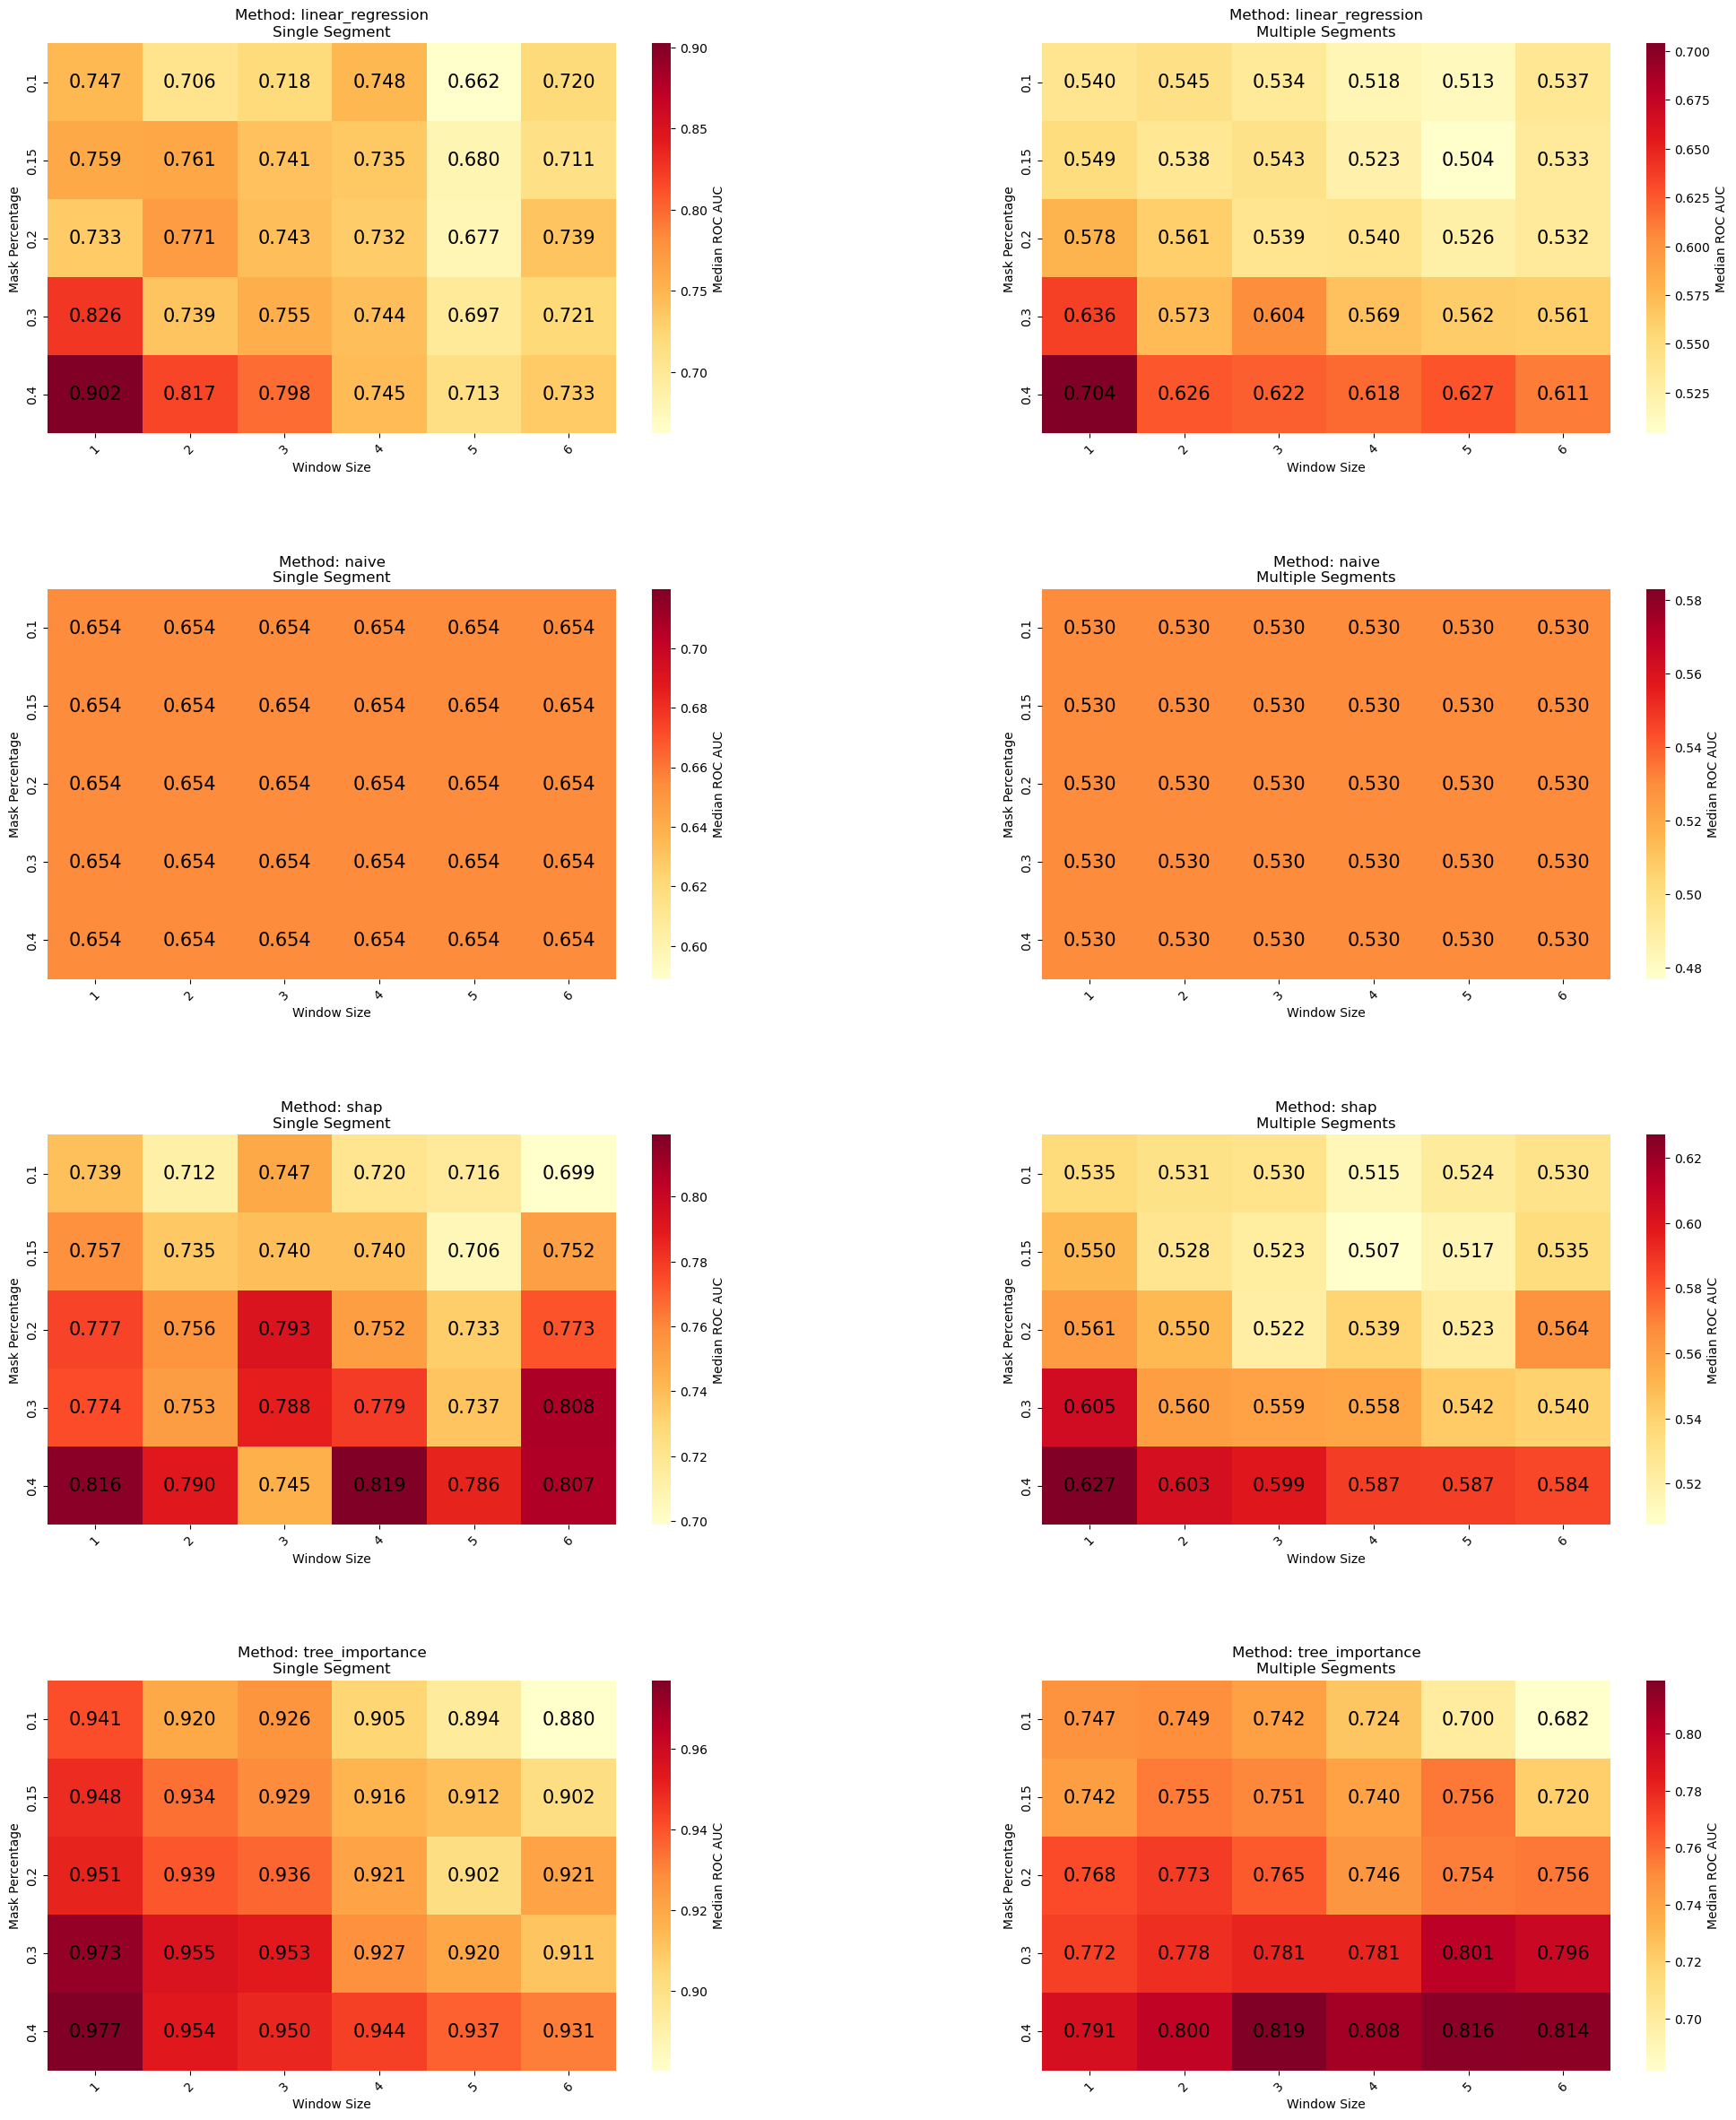

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

def plot_roc_auc_heatmaps(df, output_path=None):
    """
    Create heatmaps of ROC AUC values grouped by method and segment_count (1 or >1).
    
    Args:
        df: DataFrame with columns: method, p, m, roc_auc, segment_count
        output_path: Optional path to save the figure
    """
    # Get unique methods
    methods = df['method'].unique()
    
    # Create two categories: segment_count=1 and segment_count>1
    df['segment_category'] = df['segment_count'].apply(lambda x: 'Single Segment' if x == 1 else 'Multiple Segments')
    
    # Calculate number of rows and columns needed for subplots
    n_methods = len(methods)
    n_categories = 2  # Always 2 categories now: single and multiple segments
    n_cols = 2  # Two columns for better comparison
    n_rows = n_methods  # One row per method
    
    # Create figure
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 6*n_rows))
    if n_rows == 1:
        axes = np.expand_dims(axes, axis=0)
    
    for method_idx, method in enumerate(methods):
        method_data = df[df['method'] == method]
        
        for cat_idx, (category, category_label) in enumerate([
            (1, 'Single Segment'),
            (2, 'Multiple Segments')
        ]):
            # Filter data based on category
            if category == 1:
                data = method_data[method_data['segment_count'] == 1]
            else:
                data = method_data[method_data['segment_count'] > 1]
            
            # Create pivot table for heatmap
            pivot_data = data.pivot_table(
                values='roc_auc',
                index='p',
                columns='m',
                aggfunc='median'
            )
            # Create heatmap
            ax = axes[method_idx, cat_idx]
            if not pivot_data.empty:
                sns.heatmap(
                    pivot_data,
                    fmt='.3f',
                    cmap='YlOrRd',
                    ax=ax,
                    cbar_kws={'label': 'Median ROC AUC'},
                    annot_kws={"size": 12}  # Adjust as necessary
                )

                # Customize plot
                mask_percentages = pivot_data.index
                window_sizes = pivot_data.columns
                results = pivot_data.values

                for i in range(len(mask_percentages)):
                    for j in range(len(window_sizes)):
                        value = results[i, j]
                        if not np.isnan(value):
                            ax.text(j + 0.5, i + 0.5, f'{value:.3f}',
                                    ha='center', va='center',
                                    color='black', fontsize=15)

                # Customize plot
                ax.set_title(f'Method: {method}\n{category_label}', fontsize=12)
                ax.set_xlabel('Window Size', fontsize=10)
                ax.set_ylabel('Mask Percentage', fontsize=10)
                ax.tick_params(axis='x', rotation=45)

    plt.tight_layout(pad=2.0)
    plt.subplots_adjust(hspace=0.4, wspace=0.4)  # Fine-tune layout

    if output_path:
        plt.savefig(output_path, bbox_inches='tight', dpi=300)
        
    return fig

fig = plot_roc_auc_heatmaps(merge_df, 'heatmaps.png')

## Leo Metric

In [17]:
merge_df['normalized_score_difference'].describe()

count    10800.000000
mean         0.413231
std          0.386886
min         -1.208598
25%          0.159064
50%          0.395897
75%          0.636029
max          2.594606
Name: normalized_score_difference, dtype: float64

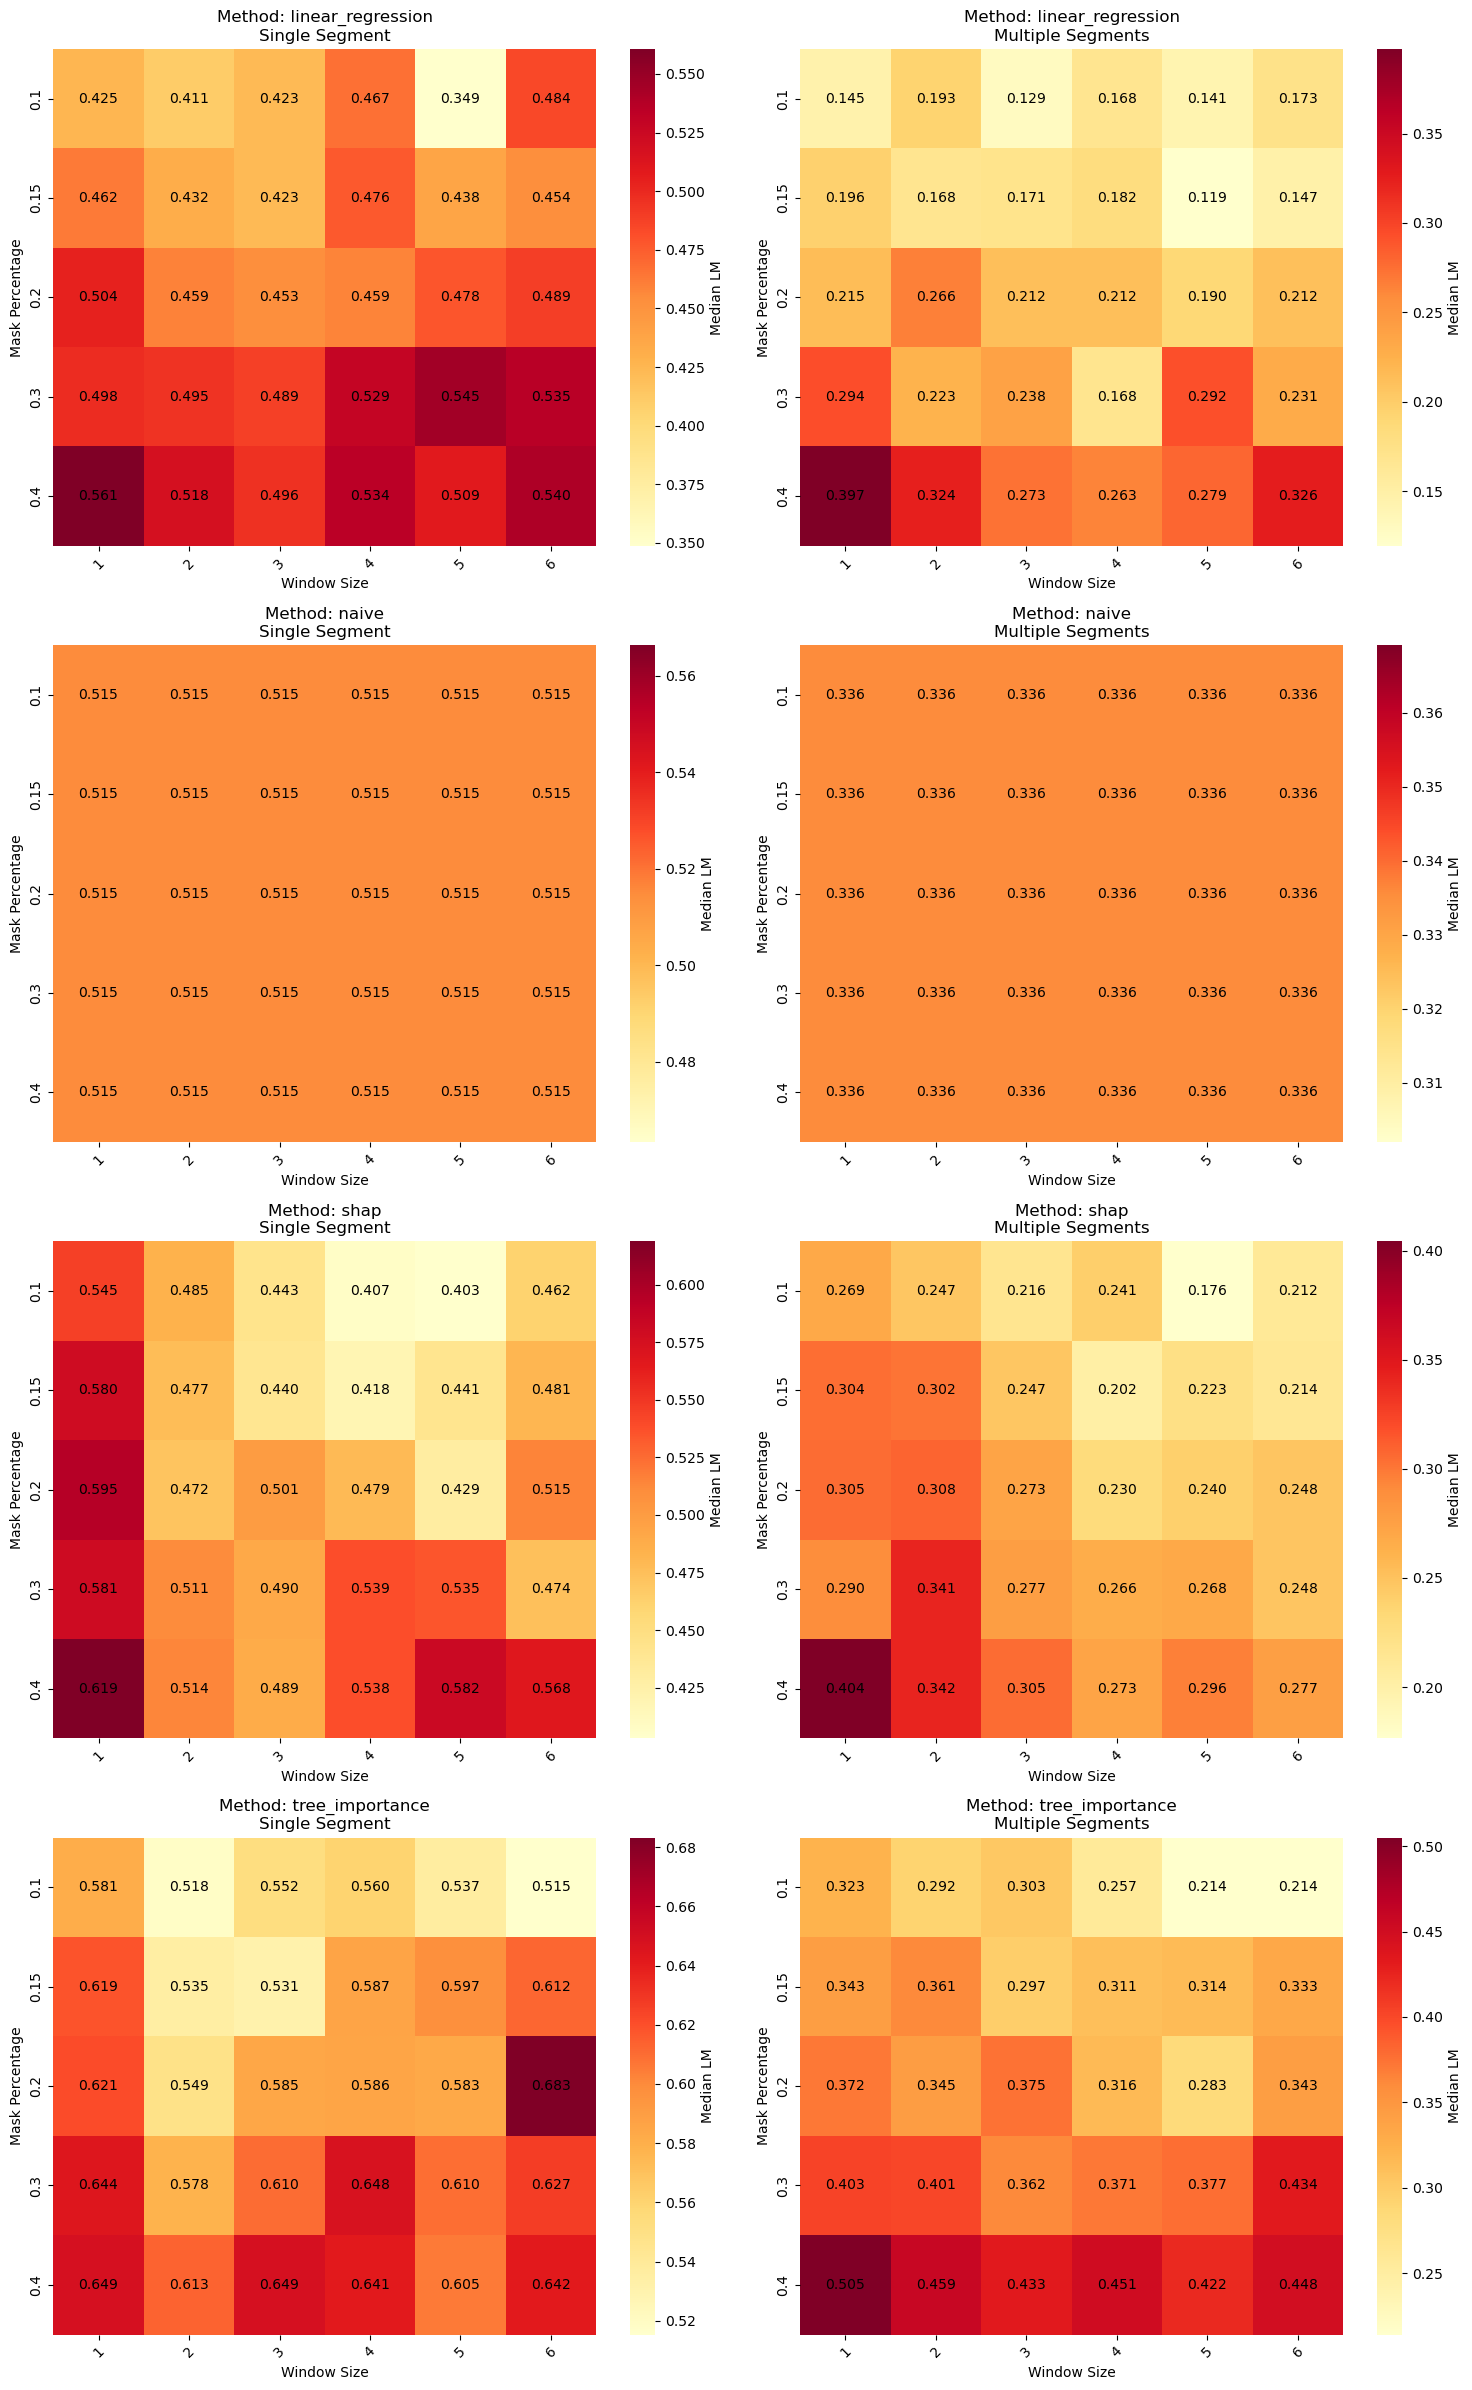

<Figure size 640x480 with 0 Axes>

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

def plot_leo_metric_heatmaps(df, output_path=None):
    """
    Create heatmaps of ROC AUC values grouped by method and segment_count (1 or >1).
    
    Args:
        df: DataFrame with columns: method, p, m, roc_auc, segment_count
        output_path: Optional path to save the figure
    """
    # Get unique methods
    methods = df['method'].unique()
    
    # Create two categories: segment_count=1 and segment_count>1
    df['segment_category'] = df['segment_count'].apply(lambda x: 'Single Segment' if x == 1 else 'Multiple Segments')
    
    # Calculate number of rows and columns needed for subplots
    n_methods = len(methods)
    n_categories = 2  # Always 2 categories now: single and multiple segments
    n_cols = 2  # Two columns for better comparison
    n_rows = n_methods  # One row per method
    
    # Create figure
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 6*n_rows))
    if n_rows == 1:
        axes = axes.reshape(1, -1)
    
    for method_idx, method in enumerate(methods):
        method_data = df[df['method'] == method]
        
        for cat_idx, (category, category_label) in enumerate([
            (1, 'Single Segment'),
            (2, 'Multiple Segments')
        ]):
            # Filter data based on category
            if category == 1:
                data = method_data[method_data['segment_count'] == 1]
            else:
                data = method_data[method_data['segment_count'] > 1]
            
            # Create pivot table for heatmap
            pivot_data = data.pivot_table(
                values='normalized_score_difference',
                index='p',
                columns='m',
                aggfunc='median'
            ).reindex(
                index=np.sort(df['p'].unique()), 
                columns=np.sort(df['m'].unique()), 
                fill_value=0  # Adjust as necessary
            )
            
            # Create heatmap
            ax = axes[method_idx, cat_idx]
            if not pivot_data.empty:
                sns.heatmap(
                    pivot_data,
                    fmt='.3f',
                    cmap='YlOrRd',
                    ax=ax,
                    cbar_kws={'label': 'Median LM'},
                    annot_kws={"size": 15}  # Adjust as necessary
                )
                
                mask_percentages = pivot_data.index
                window_sizes = pivot_data.columns
                results = pivot_data.values

                for i in range(len(mask_percentages)):
                    for j in range(len(window_sizes)):
                        value = results[i, j]
                        if not np.isnan(value):
                            ax.text(j + 0.5, i + 0.5, f'{value:.3f}',
                                    ha='center', va='center',
                                    color='black', fontsize=10)

                # Customize plot
                ax.set_title(f'Method: {method}\n{category_label}', fontsize=12)
                ax.set_xlabel('Window Size', fontsize=10)
                ax.set_ylabel('Mask Percentage', fontsize=10)
                ax.tick_params(axis='x', rotation=45)

    
    plt.tight_layout()
    plt.show()
    if output_path:
        plt.savefig(output_path, bbox_inches='tight', dpi=300)
        
    return fig

fig = plot_leo_metric_heatmaps(merge_df, 'heatmaps_lm.png')

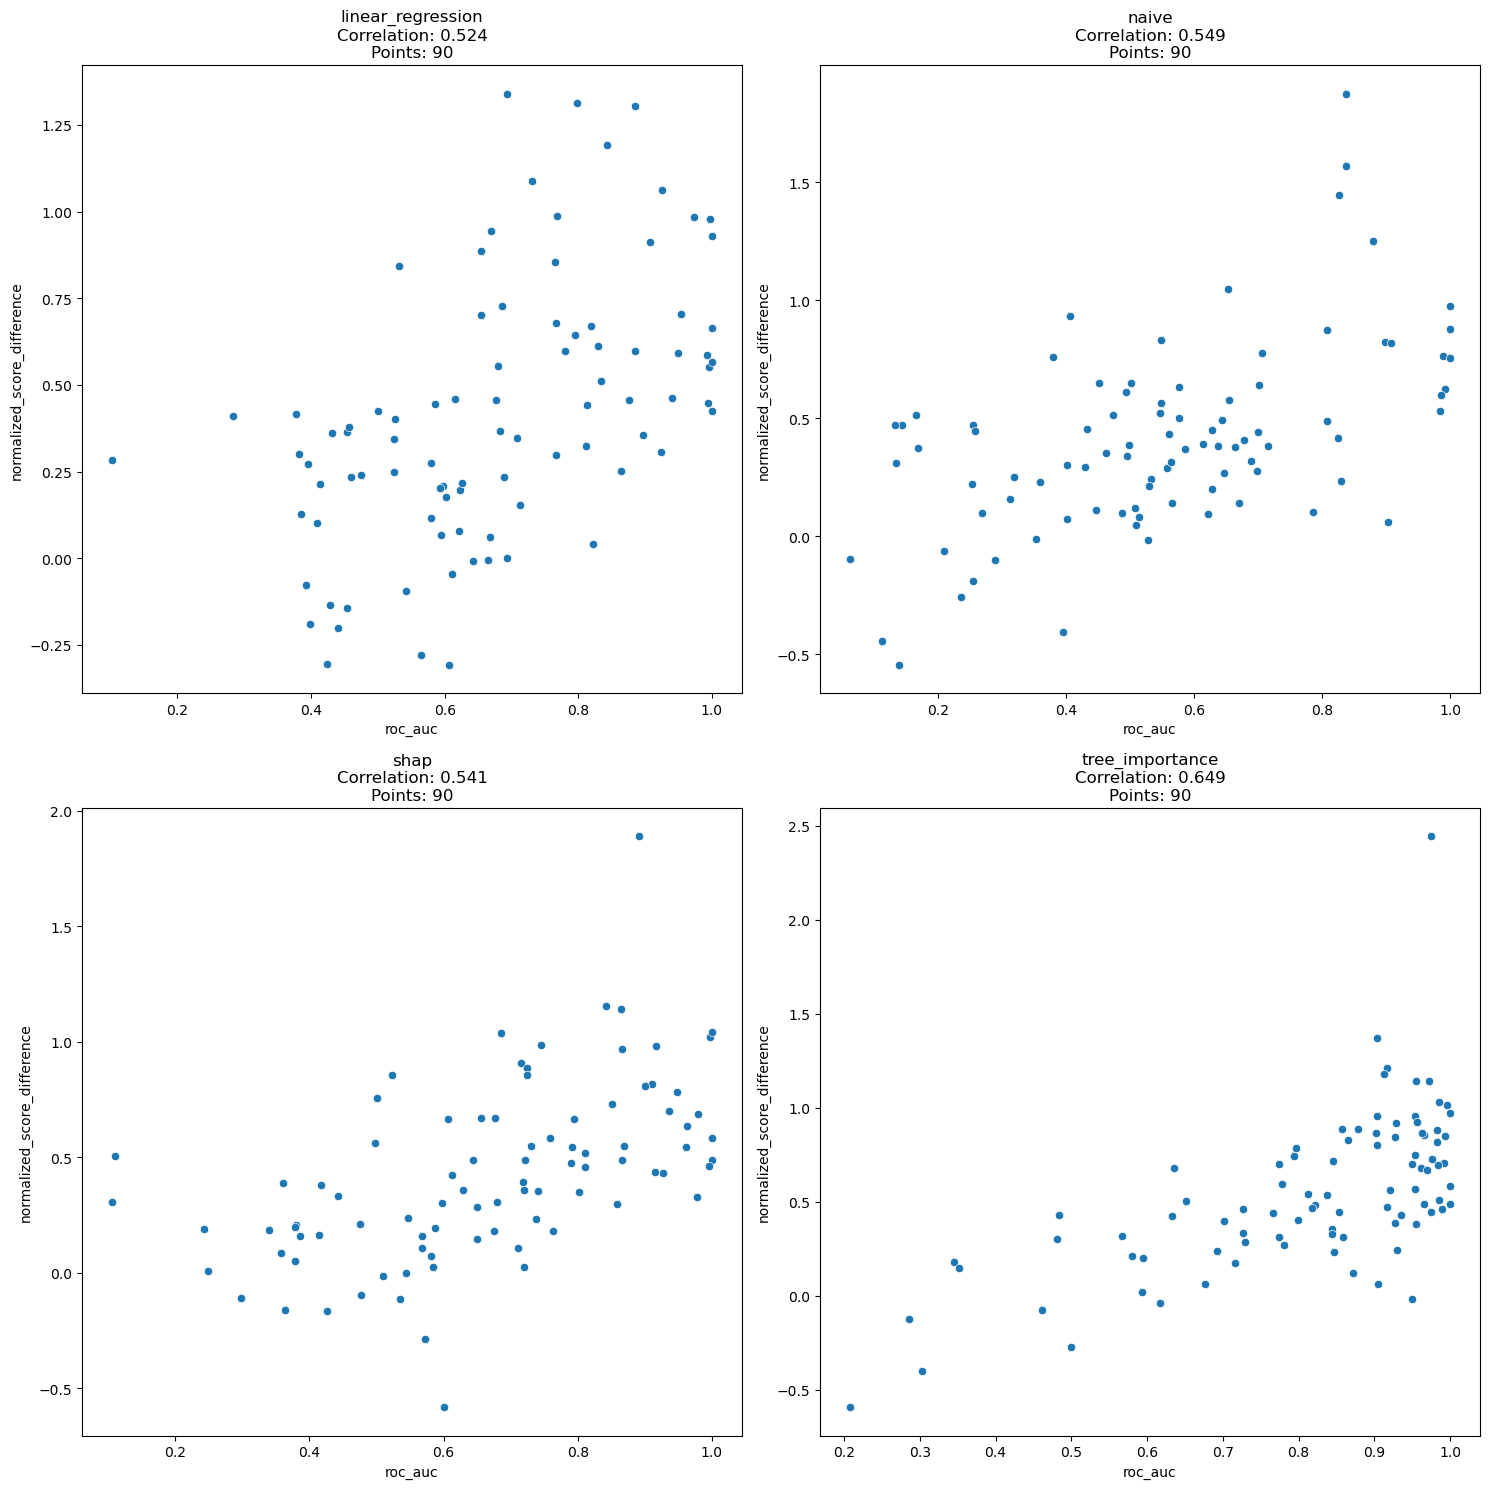

linear_regression: Correlation = 0.524, Number of points = 90
naive: Correlation = 0.549, Number of points = 90
shap: Correlation = 0.541, Number of points = 90
tree_importance: Correlation = 0.649, Number of points = 90


In [21]:
import seaborn as sns

methods = merge_df['method'].unique()

window_size = 3
mask_percentage = 0.4
fig, axes = plt.subplots(2, 2, figsize=(15, 15))
axes = axes.ravel()

for idx, method in enumerate(methods):
    method_df = merge_df[(merge_df['method'] == method) & 
                        (merge_df['m'] == window_size) & 
                        (merge_df['p'] == mask_percentage)]
    
    # Count points
    num_points = len(method_df)
    
    # Calculate correlation
    correlation = method_df['roc_auc'].corr(method_df['normalized_score_difference'])
    
    # Scatter plot
    sns.scatterplot(data=method_df, x='roc_auc', y='normalized_score_difference', ax=axes[idx])
    axes[idx].set_title(f'{method}\nCorrelation: {correlation:.3f}\nPoints: {num_points}')
    axes[idx].set_xlabel('roc_auc')
    axes[idx].set_ylabel('normalized_score_difference')

plt.tight_layout()
plt.show()

# Print correlations and point counts
for method in methods:
    method_df = merge_df[(merge_df['method'] == method) & 
                        (merge_df['m'] == window_size) & 
                        (merge_df['p'] == mask_percentage)]
    num_points = len(method_df)
    correlation = method_df['roc_auc'].corr(method_df['normalized_score_difference'])
    print(f"{method}: Correlation = {correlation:.3f}, Number of points = {num_points}")

In [15]:
interesting_cases = merge_df[
    (merge_df['roc_auc'] > 0.9) & 
    (merge_df['normalized_score_difference'] < 0.1) &
    (merge_df['method'] == 'tree_importance')
]

interesting_cases

,filename,event_label,actual_score,score_curve_descending_higher,score_curve_descending_lower,gt_curve_descending,importance_curve_descending,method,p,m,roc_auc,segment_count,type_segment,pair,normalized_score_difference,segment_category
8139,00wORCOKNHw,Horse,1.489873,"[1.135658621788025, 1.1254944801330566, 1.2274...","[1.4815775156021118, 1.325669288635254, 1.3346...","[1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ...","[0.1708637791630636, 0.17004744639055777, 0.09...",tree_importance,0.10,1,0.931034,1,single,"(00wORCOKNHw, Horse)",-0.079049,Single Segment
8156,-aOxR6ILsw8,Engine starting,-0.344366,"[-0.3672921657562256, -0.9645992517471313, -0....","[-0.8926585912704468, -1.1304887533187866, -1....","[0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, ...","[0.19494632540408627, 0.13098929086276673, 0.1...",tree_importance,0.10,1,0.945652,1,single,"(-aOxR6ILsw8, Engine starting)",-0.011705,Single Segment
8228,00wORCOKNHw,Horse,1.489873,"[1.135658621788025, 1.267360806465149, 1.35503...","[1.4815775156021118, 1.3396652936935425, 1.373...","[1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ...","[0.17284890034369202, 0.16521729522900266, 0.0...",tree_importance,0.10,2,0.919540,1,single,"(00wORCOKNHw, Horse)",-0.110741,Single Segment
8246,-aOxR6ILsw8,Engine starting,-0.344366,"[-0.3672921657562256, -0.9484679698944092, -0....","[-0.8854808211326599, -1.1001089811325073, -1....","[0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, ...","[0.2811344461472099, 0.1419573540426603, 0.117...",tree_importance,0.10,2,0.941576,1,single,"(-aOxR6ILsw8, Engine starting)",0.000478,Single Segment
8318,00wORCOKNHw,Horse,1.489873,"[1.4296070337295532, 1.0372201204299927, 1.169...","[1.4815775156021118, 1.325669288635254, 1.3453...","[0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...","[0.2867374114485232, 0.1386058079992851, 0.112...",tree_importance,0.10,3,0.916667,1,single,"(00wORCOKNHw, Horse)",-0.163818,Single Segment
8336,-aOxR6ILsw8,Engine starting,-0.344366,"[-0.3672921657562256, -0.7106750011444092, -0....","[-0.8776671290397644, -1.0741819143295288, -1....","[0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, ...","[0.4145066329406987, 0.12318284252591881, 0.10...",tree_importance,0.10,3,0.929348,1,single,"(-aOxR6ILsw8, Engine starting)",-0.030099,Single Segment
8426,-aOxR6ILsw8,Engine starting,-0.344366,"[-0.3672921657562256, -0.7106750011444092, -0....","[-0.9154394268989563, -0.971803605556488, -0.9...","[0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, ...","[0.44222735257013884, 0.194865768441457, 0.088...",tree_importance,0.10,4,0.923913,1,single,"(-aOxR6ILsw8, Engine starting)",0.019465,Single Segment
8679,00wORCOKNHw,Horse,1.489873,"[1.2724961042404175, 1.1254944801330566, 1.227...","[1.4469128847122192, 1.334392786026001, 1.3957...","[1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, ...","[0.2106516872551137, 0.19995551028651617, 0.06...",tree_importance,0.15,1,0.948276,1,single,"(00wORCOKNHw, Horse)",-0.024408,Single Segment
8696,-aOxR6ILsw8,Engine starting,-0.344366,"[-0.3672921657562256, -0.9645992517471313, -0....","[-0.9348437190055847, -1.0741146802902222, -1....","[0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, ...","[0.16683095950085428, 0.14701740790899492, 0.1...",tree_importance,0.15,1,0.948370,1,single,"(-aOxR6ILsw8, Engine starting)",0.026096,Single Segment
8769,00wORCOKNHw,Horse,1.489873,"[1.135658621788025, 1.267360806465149, 1.22746...","[1.4067350625991821, 1.402549386024475, 1.2043...","[1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, ...","[0.21236982322259007, 0.14056181036944015, 0.0...",tree_importance,0.15,2,0.933908,1,single,"(00wORCOKNHw, Horse)",-0.057516,Single Segment


In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

def plot_single_row(df, row_index=0):
    row = df.iloc[row_index]
    
    ascending_scores = eval(row['score_curve_descending_higher']) - row['actual_score']
    descending_scores = eval(row['score_curve_descending_lower']) - row['actual_score']
    ascending_scores = np.concatenate(([0], ascending_scores))
    descending_scores = np.concatenate(([0], descending_scores))

    x_plot = np.arange(0, len(ascending_scores))

    plt.figure(figsize=(12, 6))
    
    plt.plot(x_plot, ascending_scores, label=f'Score (higher to lower)', color='blue', linewidth=2)
    plt.plot(x_plot, descending_scores, label=f'Score (lower to higher)', color='red', linewidth=2)

    
    plt.title(f'Score Curve for {row["event_label"]}\nFile: {row["filename"]}n\AUC={row["roc_auc"]:.2f}, lm={row["normalized_score_difference"]}\nMETHOD: {row["method"]}')
    plt.xlabel('Index')
    plt.ylabel('Score')
    plt.grid(True, alpha=0.3)
    plt.legend()
    
    plt.tight_layout()
    plt.show()

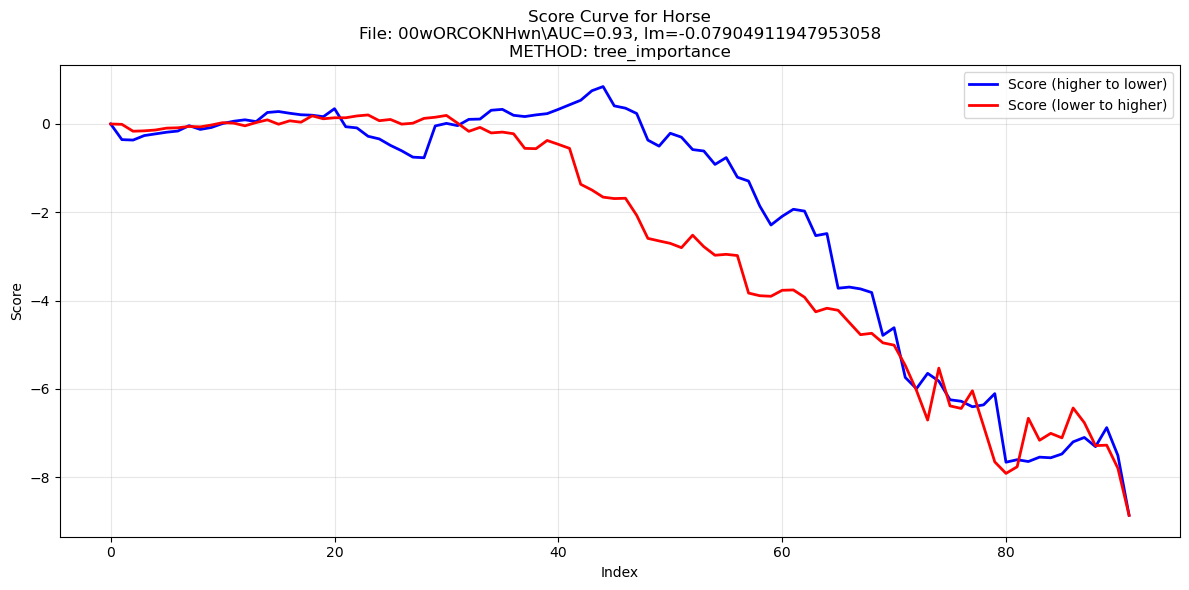

In [17]:
plot_single_row(merge_df, 8139)

In [ ]:
plot_single_row(merge_df, specific_row.name)

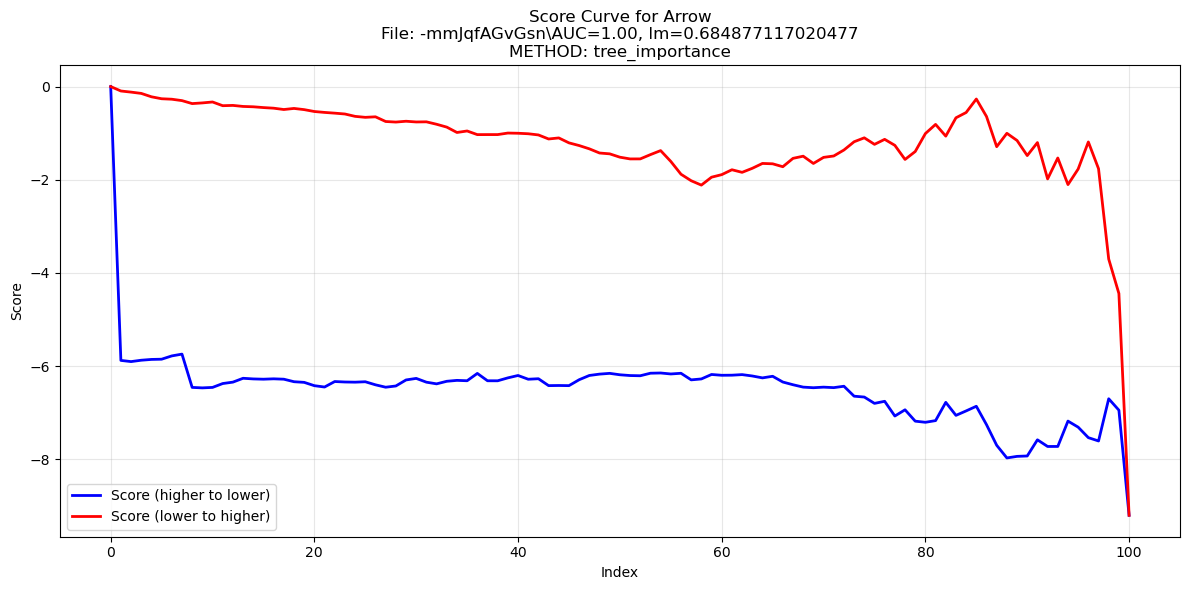

In [39]:
specific_row = merge_df[(merge_df['filename'] == '-mmJqfAGvGs') & 
                  (merge_df['event_label'] == 'Arrow') & (merge_df['method']=='tree_importance')].iloc[0]
plot_single_row(merge_df, specific_row.name)

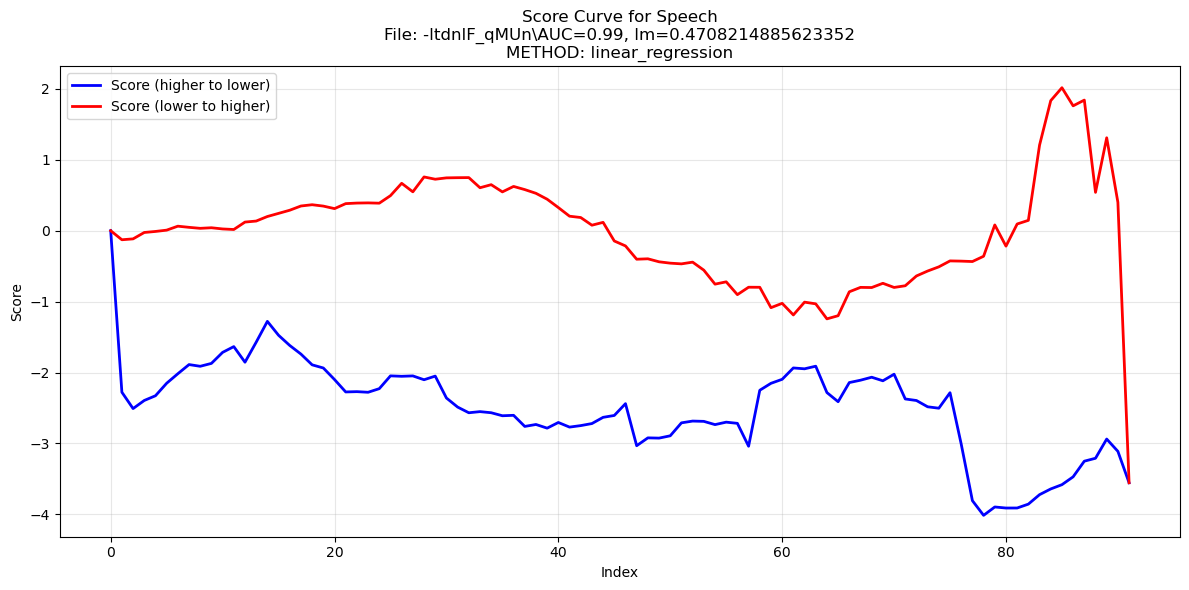

In [40]:
plot_single_row(merge_df, 9)

# OTRO

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def plot_cell_distribution(df, p_val, m_val, segment_type='all'):
    """
    Create boxplots comparing methods for a specific p and m value combination.
    
    Args:
        df: DataFrame with columns: method, p, m, normalized_score_difference, segment_count
        p_val: The mask percentage value
        m_val: The window size value
        segment_type: 'single' for segment_count=1, 'multiple' for segment_count>1, 'all' for both
    """
    # Filter data for the specific combination
    mask = (df['p'] == p_val) & (df['m'] == m_val)
    
    if segment_type == 'single':
        mask &= (df['segment_count'] == 1)
    elif segment_type == 'multiple':
        mask &= (df['segment_count'] > 1)
    
    cell_data = df[mask]
    
    # Create figure
    plt.figure(figsize=(12, 6))
    
    # Create boxplot
    sns.boxplot(data=cell_data, x='method', y='roc_auc')
    stats = cell_data.groupby('method')['roc_auc'].describe()
    
    # Add title and labels
    plt.title(f'Distribution Comparison for p={p_val}, m={m_val}\n'
              f'Segment Type: {segment_type}\n'
              f'n={len(cell_data)}')
    plt.xlabel('Method')
    plt.ylabel('Normalized Score Difference')
    
    # Rotate x-axis labels for better readability
    plt.xticks(rotation=45)
    
    # Adjust layout
    plt.tight_layout()
    
    return plt.gcf()

fig = plot_cell_distribution(merge_df, 
                           p_val=0.4, 
                           m_val=1, 
                           segment_type='multiple')